# PDBBind 2020

Downloaded from https://pdbbind.oss-cn-hangzhou.aliyuncs.com/download/PDBbind_v2020_PP.tar.gz (Cloud CDN of http://www.pdbbind.org.cn/download/PDBbind_v2020_PP.tar.gz)

In [1]:
import os
import pandas as pd
from collections import defaultdict
from abag_affinity.utils.config import read_yaml, get_data_paths

config = read_yaml("../../abag_affinity/config.yaml")
info_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["PDBBind"]["folder_path"], config["RESOURCES"]["PDBBind"]["info_file"])

In [2]:
with open(info_path) as f:
    lines = f.readlines()

all_records = []

for line in lines[6:]:
    line = [ token for token in line.split(" ") if token != "" ]
    if "IC50" in line[3]:
        affinity_type = line[3][:4]
        affinity = line[3][5:]
    else:
        affinity_type = line[3][:2]
        affinity = line[3][3:]
    affinity_value = affinity[:-2]
    affinity_unit = affinity[-2:]
    
    all_records.append({
        "pdb": line[0],
        "resolution": line[1],
        "release_year": line[2],
        "affinty": float(affinity_value),
        "affinity_unit": affinity_unit,
        "affinity_type": affinity_type,
        "ligand_name": " ".join(line[6:])
    })
    
summary_df = pd.DataFrame.from_records(all_records)

In [3]:
print("Number of Protein-Protein Interactions with binding affinity >>>", len(summary_df))

Number of Protein-Protein Interactions with binding affinity >>> 2852


In [4]:
summary_df["affinity_unit"].unique()

array(['nM', 'pM', 'uM', 'fM', 'mM'], dtype=object)

In [5]:
convert_unit = {
    'mM': 1e03,
    'uM': 1e06,
    "nM": 1e09,
    'pM': 1e12,
    'fM': 1e15
}
summary_df["Kd"] = summary_df.apply(lambda row: row["affinty"] / convert_unit[row["affinity_unit"]], axis=1)

In [6]:
import numpy as np
gas_constant =  8.31446261815324 # 0.0821

def calc_delta_g(row):
    delta_g = gas_constant * row["temperature_kelvin"] * np.log(row["Kd"])
    return delta_g / 4184 # convert to kcal

In [7]:
summary_df["temperature_kelvin"] = 298.15 # assume temperature of 25° Celcius

summary_df["delta_G"] = summary_df.apply(lambda row: calc_delta_g(row), axis=1)

summary_df["-log(Kd)"] = summary_df.apply(lambda row: -np.log10(row["Kd"]), axis=1)

In [8]:
summary_df

,pdb,resolution,release_year,affinty,affinity_unit,affinity_type,ligand_name,Kd,temperature_kelvin,delta_G,-log(Kd)
0,1fc2,2.80,1981,22.5,nM,Kd,"(224-mer) Human Fc fragment, Kd=22.5+/-4.6nM, ...",2.250000e-08,298.15,-10.433512,7.647817
1,3sgb,1.80,1983,17.9,pM,Kd,"(56-mer) TURKEY OVOMUCOID INHIBITOR (OMTKY3), ...",1.790000e-11,298.15,-14.661763,10.747147
2,2tgp,1.90,1983,2.4,uM,Kd,"(58-mer) TRYPSIN INHIBITOR, 2.4 x 10-6M\n",2.400000e-06,298.15,-7.666780,5.619789
3,2ptc,1.90,1983,60.0,fM,Kd,(58-mer) Kd=6x10-14M is for trypsin and the pa...,6.000000e-14,298.15,-18.037868,13.221849
4,2sni,2.10,1988,2.0,pM,Kd,"(83-mer) CHYMOTRYPSIN INHIBITOR 2, Kd=2 x 10-1...",2.000000e-12,298.15,-15.960285,11.698970
...,...,...,...,...,...,...,...,...,...,...,...
2847,6bx8,1.98,2019,0.2,uM,Ki,(80-mer)\n,2.000000e-07,298.15,-9.139050,6.698970
2848,6dwf,1.94,2019,1.3,nM,Ki,(169-mer)\n,1.300000e-09,298.15,-12.122776,8.886057
2849,6n9d,2.67,2019,17.8,pM,Ki,(184-mer)\n,1.780000e-11,298.15,-14.665082,10.749580
2850,6mav,2.37,2019,33.5,pM,Ki,(184-mer)\n,3.350000e-11,298.15,-14.290426,10.474955


### Remove data already in Dataset 1

In [9]:
from abag_affinity.utils.config import get_data_paths
dataset_v1_path, _ = get_data_paths(config, "Dataset_v1")
dataset_v1_df = pd.read_csv(dataset_v1_path)
data_v1_ids = set(dataset_v1_df["pdb"].unique().tolist())

In [10]:
summary_df = summary_df[~summary_df["pdb"].isin(data_v1_ids)]

In [11]:
#summary_df.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["PDBBind"]["folder_path"], config["DATA"]["PDBBind"]["summary"]), index=False)

In [12]:
from abag_affinity.utils.pdb_reader import read_file
from Bio.SeqUtils import seq1
import warnings
warnings.filterwarnings("ignore")

pdb_path = os.path.join(config["RESOURCES"]["path"], config["RESOURCES"]["PDBBind"]["folder_path"], config["RESOURCES"]["PDBBind"]["pdb_path"])

def read_pdb(pdb_id):
    path = os.path.join(pdb_path, pdb_id + ".ent.pdb")

    structure, header = read_file(pdb_id, path)
    chains = structure.get_chains()
    chain_ids = [chain.id for chain in chains]
    
    chain_residue_count = {}
    
    for model in structure:
        for chain in model:
            chain_residues = 0
            for r in chain.get_residues():
                if r.id[0] == ' ' and r.resname not in ["UNK", "HOH", "H_GOL", "W"]:
                    chain_residues +=1
            chain_residue_count[chain.id.lower()] = chain_residues
    
    compound_info = header.get("compound")
    if compound_info is None:
        return "No Compound Info"
    
    chain_info = {}
    molecules = []
    mol_id2chain = defaultdict(list)
    for info in compound_info.values():
        if isinstance(info, str):
            print(info)
            return "Invalid Information format"
        if info.get("molecule") is not None:
            molecule = info.get("molecule")
            if molecule == 'uncharacterized protein':
                return "Uncharacterized protein in complex"
            if "light" in molecule:
                molecule = molecule[:molecule.find("light")]
            if "heavy" in molecule:
                molecule = molecule[:molecule.find("heavy")]
            if molecule in molecules:
                mol_id = molecules.index(molecule)
            else:
                mol_id = len(molecules)
                molecules.append(molecule)
            chain_info[info["chain"]] = mol_id
            mol_id2chain[mol_id].append(info["chain"])
        else:
            return "No Molecule Info"
    
    for chain in structure.get_chains():
        if chain.id.lower() not in chain_info:
            return "No Info for chain {}".format(chain.id)
    
    if len(molecules) > 2:
        return "Too many molecules"
    

    for mol_id, chains in mol_id2chain.items():
        for chain in chains:
            if chain not in chain_residue_count or chain_residue_count[chain] == 0:
                    return "Not all chains have residues"
    #print(chain_residue_count)
    return chain_info

In [13]:
from tqdm.auto import tqdm
tqdm.pandas()

if "chain_infos" not in summary_df:
    chain_infos = summary_df["pdb"].progress_apply(lambda id: read_pdb(id))
    summary_df["chain_infos"] = chain_infos

  0%|          | 0/2532 [00:00<?, ?it/s]

In [14]:
print("{} total structures with two molecules and info available".format(chain_infos.apply(lambda chain_info: not isinstance(chain_info, str)).sum()))
print("{} total structures with more than two molecules and info available".format(chain_infos.apply(lambda chain_info: chain_info == "Too many molecules" ).sum()))

968 total structures with two molecules and info available
193 total structures with more than two molecules and info available


In [15]:
#summary_df

In [16]:
#summary_df[summary_df["pdb"] == "3sgb"]["pdb"].progress_apply(lambda id: read_pdb(id))

### Clean dataset

Remove all entries that do not have information for two proteins


In [17]:
mask = summary_df["chain_infos"].apply(lambda x: isinstance(x, dict))

cleaned_summary = summary_df[mask]

mask = cleaned_summary["chain_infos"].apply(lambda x: list(x.values()).count(list(x.values())[0]) != len(x.values()))

cleaned_summary = cleaned_summary[mask]

In [18]:
print("Number of pdbs after cleansing >>> {}".format(len(cleaned_summary)))

Number of pdbs after cleansing >>> 960


In [19]:
cleaned_summary.to_csv(os.path.join(config["DATA"]["path"], config["DATA"]["PDBBind"]["folder_path"], config["DATA"]["PDBBind"]["summary"]), index=False)

### Affinity distribution

<AxesSubplot:>

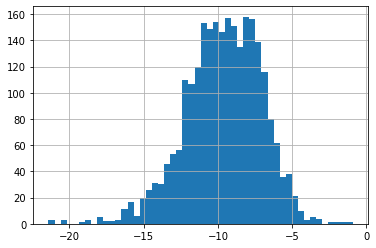

In [20]:
summary_df["delta_G"].hist(bins=50)

<AxesSubplot:>

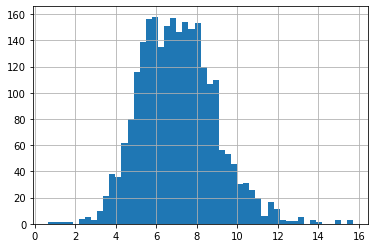

In [21]:
summary_df["-log(Kd)"].hist(bins=50)